In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd '/content/gdrive/My Drive/Colab Notebooks'

/content/gdrive/.shortcut-targets-by-id/1f4_bhvRaJhUMnZZ4MeBoNGoM9eWVOzBa/Colab Notebooks


In [3]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from math import ceil
from random import shuffle,seed
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.datasets import cifar100
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Activation, UpSampling2D, add, GlobalAveragePooling2D
from keras import backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import activations
from random import shuffle
from sklearn.model_selection import StratifiedKFold

from keras.applications.resnet import ResNet50, preprocess_input

from keras.preprocessing.image import load_img,img_to_array

seed(123456)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
True


# Funciones auxiliares

In [4]:
#########################################################################
######## FUNCIÓN PARA CARGAR Y MODIFICAR EL CONJUNTO DE DATOS ###########
#########################################################################

# A esta función solo se la llama una vez. Devuelve 4 
# vectores conteniendo, por este orden, las imágenes
# de entrenamiento, las clases de las imágenes de
# entrenamiento, las imágenes del conjunto de test y
# las clases del conjunto de test.

def cargarImagenes(visualizeFlag=False):
    # Cargamos Cifar100. Cada imagen tiene tamaño
    # (32 , 32, 3). Nos vamos a quedar con las
    # imágenes de 25 de las clases.
    (x_train, y_train), (x_test, y_test) = cifar100.load_data (label_mode ='fine')

    # summarize loaded dataset
    print('Summary original dataset: ')
    print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
    print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    train_idx = np.isin(y_train, np.arange(25))
    train_idx = np.reshape (train_idx, -1)
    x_train = x_train[train_idx]
    y_train = y_train[train_idx]
    test_idx = np.isin(y_test, np.arange(25))
    test_idx = np.reshape(test_idx, -1)
    x_test = x_test[test_idx]
    y_test = y_test[test_idx]

    # Transformamos los vectores de clases en matrices.
    # Cada componente se convierte en un vector de ceros
    # con un uno en la componente correspondiente a la
    # clase a la que pertenece la imagen. Este paso es
    # necesario para la clasificación multiclase en keras.
    y_train = keras.utils.np_utils.to_categorical(y_train, 25)
    y_test = keras.utils.np_utils.to_categorical(y_test, 25)

    if visualizeFlag:
      number_images_per_row = 3
      result = np.where(y_train == 1)
      fig = pyplot.figure()
      for i in range(number_images_per_row*number_images_per_row):
        # define subplot
        label = 'Class {}'.format(result[1][i])
        pyplot.subplot(number_images_per_row,number_images_per_row,i+1).set_title(label)
        # plot raw pixel data
        pyplot.imshow(x_train[i])
      # show the figure
      fig.set_size_inches(np.array(fig.get_size_inches()) * number_images_per_row)
      pyplot.show()

    # summarize loaded dataset
    print('Summary reduced dataset: ')
    print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
    print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
    
    return x_train , y_train , x_test , y_test

#########################################################################
######## FUNCIÓN PARA MOSTRAR LA EVOLUCIÓN DEL MODELO ###################
#########################################################################

# Esta función pinta dos gráficas, una con la evolución
# de la función de pérdida en el conjunto de train y
# en el de validación, y otra con la evolución de la
# accuracy en el conjunto de train y el de validación.
# Es necesario pasarle como parámetro el historial del
# entrenamiento del modelo (lo que devuelven las
# funciones fit() y fit_generator()).
def mostrarEvolucion(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    pyplot.plot(loss)
    pyplot.plot(val_loss)
    pyplot.legend(['Training loss', 'Validation loss'])
    pyplot.show()
    
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    pyplot.plot(acc)
    pyplot.plot(val_acc)
    pyplot.legend(['Training accuracy','Validation accuracy'])
    pyplot.show()



#########################################################################
################## FUNCIÓN PARA LEER LAS IMÁGENES #######################
#########################################################################

# Dado un fichero train.txt o test.txt y el path donde se encuentran los
# ficheros y las imágenes, esta función lee las imágenes
# especificadas en ese fichero y devuelve las imágenes en un vector y 
# sus clases en otro.

def leerImagenes(vec_imagenes, path):
  clases = np.array([img.split('/')[0] for img in vec_imagenes])
  imagenes = np.array([img_to_array(load_img(path + "/" + img, 
                                             target_size = (224, 224))) 
                       for img in vec_imagenes])
  return imagenes, clases




#########################################################################
############# FUNCIÓN PARA CARGAR EL CONJUNTO DE DATOS ##################
#########################################################################

# Usando la función anterior, y dado el path donde se encuentran las
# imágenes y los archivos "train.txt" y "test.txt", devuelve las 
# imágenes y las clases de train y test para usarlas con keras
# directamente.

def cargarDatos(path):
  # Cargamos los ficheros
  train_images = np.loadtxt(path + "/train.txt", dtype = str)
  test_images = np.loadtxt(path + "/test.txt", dtype = str)
  
  # Leemos las imágenes con la función anterior
  train, train_clases = leerImagenes(train_images,path)
  test, test_clases = leerImagenes(test_images,path)
  
  # Pasamos los vectores de las clases a matrices 
  # Para ello, primero pasamos las clases a números enteros
  clases_posibles = np.unique(np.copy(train_clases))
  for i in range(len(clases_posibles)):
    train_clases[train_clases == clases_posibles[i]] = i
    test_clases[test_clases == clases_posibles[i]] = i

  # Después, usamos la función to_categorical()
  train_clases = np_utils.to_categorical(train_clases, 200)
  test_clases = np_utils.to_categorical(test_clases, 200)
  
  # Barajar los datos
  train_perm = np.random.permutation(len(train))
  train = train[train_perm]
  train_clases = train_clases[train_perm]

  test_perm = np.random.permutation(len(test))
  test = test[test_perm]
  test_clases = test_clases[test_perm]
  
  return train, train_clases, test, test_clases


#########################################################################
######## FUNCIÓN PARA OBTENER EL ACCURACY DEL CONJUNTO DE TEST ##########
#########################################################################

# Esta función devuelve el accuracy de un modelo, definido como el 
# porcentaje de etiquetas bien predichas frente al total de etiquetas.
# Como parámetros es necesario pasarle el vector de etiquetas verdaderas
# y el vector de etiquetas predichas, en el formato de keras (matrices
# donde cada etiqueta ocupa una fila, con un 1 en la posición de la clase
# a la que pertenece y 0 en las demás).

def calcularAccuracy(labels, preds):
  labels = np.argmax(labels, axis = 1)
  preds = np.argmax(preds, axis = 1)
  
  accuracy = sum(labels == preds)/len(labels)
  
  return accuracy


#########################################################################
############# FUNCIÓN AUXILIARES PRACTICA ANTERIORES ####################
#########################################################################


def normalizar_mat(im):
  minimo = min(im.ravel())
  maximo = max(im.ravel())
  rango = maximo-minimo
  return (im-minimo)/rango

def pintaI(im, figsize=(5,5)):
  im_norm = normalizar_mat(im)
  cmap = 'gray' if len(im.shape) == 2 else None
  plt.figure(figsize=figsize)
  plt.axis('off')
  plt.imshow( im_norm, cmap=cmap, vmin=0.0, vmax=1.0 )
  plt.show(block=False)

def pintaMIE(vim, titulos, ncol = 2, figsize=(12,12)):
  fig = plt.figure(figsize=figsize)
  #fig = plt.figure()
  for k, im in enumerate(vim):
    sub = fig.add_subplot( ceil(len(vim)/ncol), ncol, k + 1 )
    plt.axis('off')
    plt.title(titulos[k])
    cmap = 'gray' if len(im.shape) == 2 else None
    sub.imshow(normalizar_mat(im), cmap=cmap)
  plt.show(block=False)

# Ejercicio 3

Empezamos cargando los datos. No ejecutar si ya tenemos el binario

In [ ]:
x_train_all , y_train_all , x_test , y_test = cargarDatos("./images")

Guardamos los datos en binario para que tarde menos. Si ya los tenemos guardados entonces no ejecutar la celda. Escribe en disco.

In [ ]:
np.save('train_images.npy', x_train_all)
np.save('train_labels.npy', y_train_all)
np.save('test_images.npy', x_test)
np.save('test_labels.npy', y_test)

Si ya los tenemos guardados ejecutamos la siguiente celda para cargarlos

In [5]:
y_train_all = np.load('train_labels.npy')
x_train_all = np.load('train_images.npy')
x_test = np.load('test_images.npy')
y_test = np.load('test_labels.npy')

Definimos algunas variables globales

In [11]:
epochs = 30
batch_size = 64
opt = tf.keras.optimizers.Adam()

Hacemos un pequeño preprocesado de las imágenes. Y tomamos dos conjuntos de datos. 

En el __primer conjunto de datos__ dividimos los datos de entrenamiento en dos partes: [entrenamiento - test_val] a razón de 85-15. Luego el conjunto de entrenamiento lo partimos en otros dos [training - validacion]. Este conjunto de datos será usado para comparar varios modelos con el propósito de buscar mejoras o tunear parámetros. Por tanto, test_val hará la función de conjunto de test, training hará la función de conjunto de entrenamiento y validación hará la tarea de validación en el entrenamiento.  

En el __segundo conjunto de datos__ dividimos los datos de entrenamiento en dos partes: [entranamiento - validacion] a razón de 85-15. Este conjunto de datos tiene el propósito de usar _entrenamiento_ para entrenar el modelo, validar con _validación_ y evaluar finalmente el modelo con los datos de test.   

El motivo de hacer lo anterior se expondrá algo más detallado en la memoria e indicando en qué parte se hace cada cosa.

In [12]:
# Barajamos las imágenes
ind_train = list(range(len(x_train_all)))
ind_test = list(range(len(x_test)))
shuffle(ind_train)
shuffle(ind_test)
    
x_train_all = x_train_all[ind_train]
y_train_all = y_train_all[ind_train]
x_test = x_test[ind_test]
y_test = y_test[ind_test]

########################################################################################################
########################## [TRAINING - VALIDACION] - VAL_TEST ##########################################
########################################################################################################

# Separamos el conjunto de entrenamiento en dos: training y validacion a razon de 85-15
x_train, x_test_val, y_train, y_test_val = train_test_split(x_train_all, y_train_all, test_size=0.15)

# Separamos del conjunto de entrenamiento otro de validacion para validation Data en el entrenamiento
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)


### Usamos DataImageGenerator para aumentar los datos y normalizar

# Entrenamiento
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
datagen.fit(x_train)
train_iterator = datagen.flow(x_train, y_train, batch_size=batch_size)     

#Validación

test_val_iterator  = datagen.flow(x_test_val, y_test_val, batch_size=batch_size)  # Validación 
val_iterator  = datagen.flow(x_val, y_val, batch_size=batch_size)                 # Validacion en el fit
test_iterator = datagen.flow(x_test, y_test, batch_size=batch_size)               # Conjunto de TEST para el final

# Entrenamiento Aumentado
aug_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        horizontal_flip=True,
        zoom_range=0.4,
        rotation_range=90,
        )
aug_datagen.fit(x_train)
aug_train_iterator = aug_datagen.flow(x_train, y_train, batch_size=batch_size) # Entrenar con aumento de datos

########################################################################################################
#################################### TRAINING  - VAL_TEST ##############################################
########################################################################################################

xx_train, xx_test_val, yy_train, yy_test_val = train_test_split(x_train_all, y_train_all, test_size=0.15)

## Usamos DataImageGenerator para aumentar los datos y normalizar 

# Entrenamiento
datagen_2 = ImageDataGenerator(preprocessing_function=preprocess_input)
datagen_2.fit(xx_train)
train_iterator_2 = datagen_2.flow(xx_train, yy_train, batch_size=batch_size)     # Entrenar

# Validacion
test_val_iterator_2  = datagen_2.flow(xx_test_val, yy_test_val, batch_size=batch_size) # Validación hold-out
test_iterator_2      = datagen_2.flow(x_test, y_test, batch_size=batch_size)    # Conjunto de TEST para el final

# Entrenamiento Aumentado
aug_datagen_2 = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        horizontal_flip=True,
        zoom_range=0.4,
        rotation_range=90,
        )
aug_datagen_2.fit(xx_train)
aug_train_iterator_2 = aug_datagen_2.flow(xx_train, yy_train, batch_size=batch_size) # Entrenar con aumento de datos



Visualizamos algunas imagenes a ver que tal ha ido

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


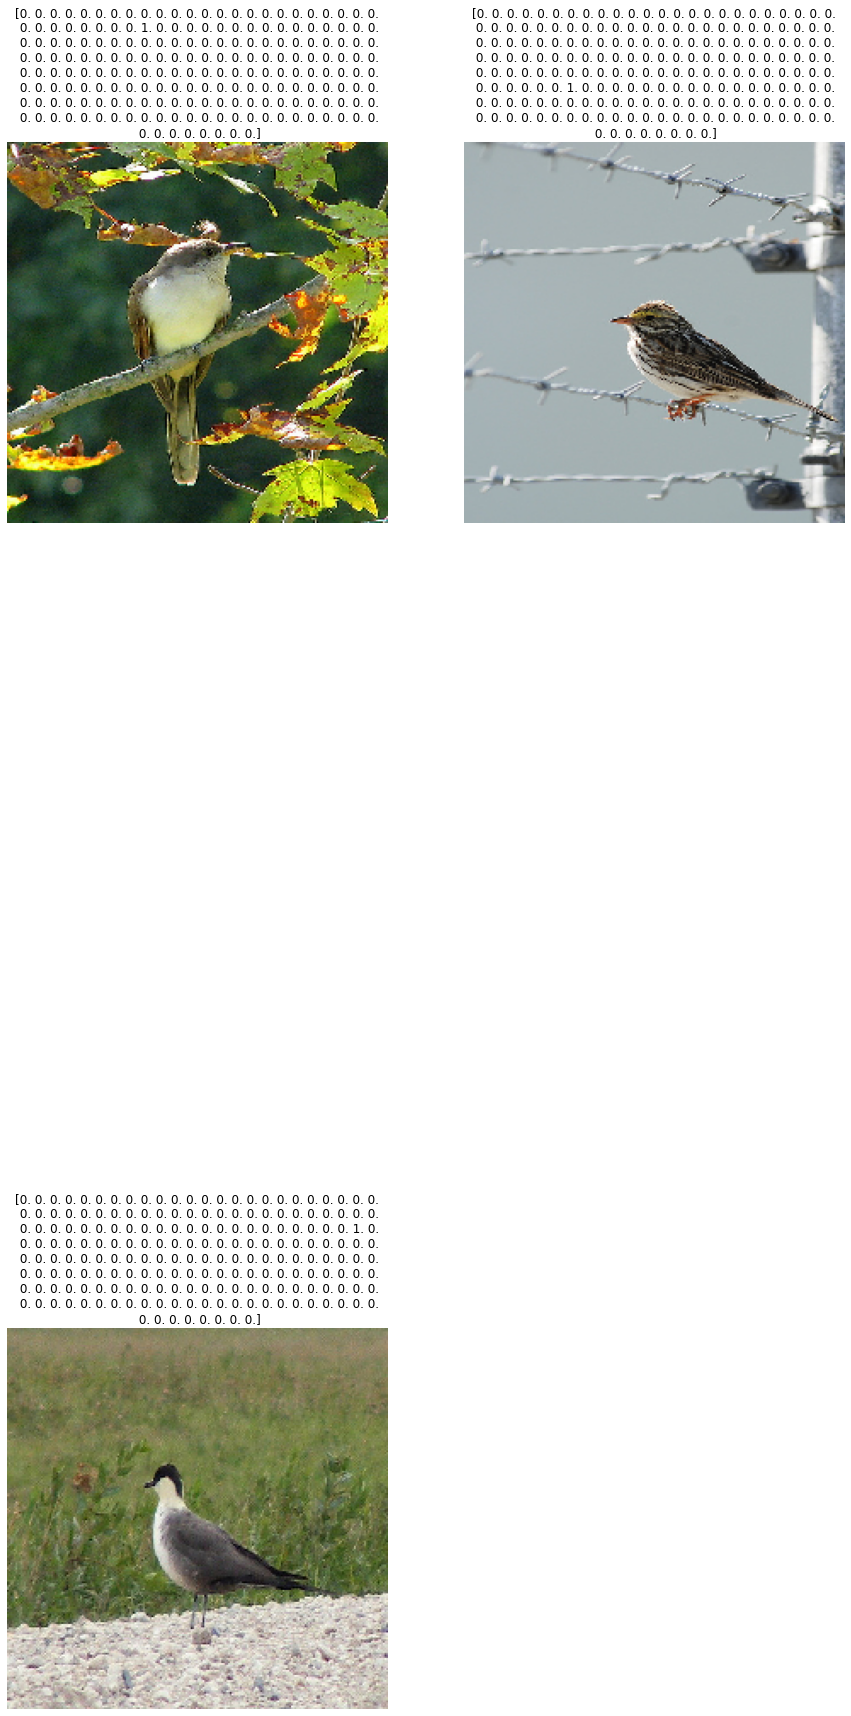

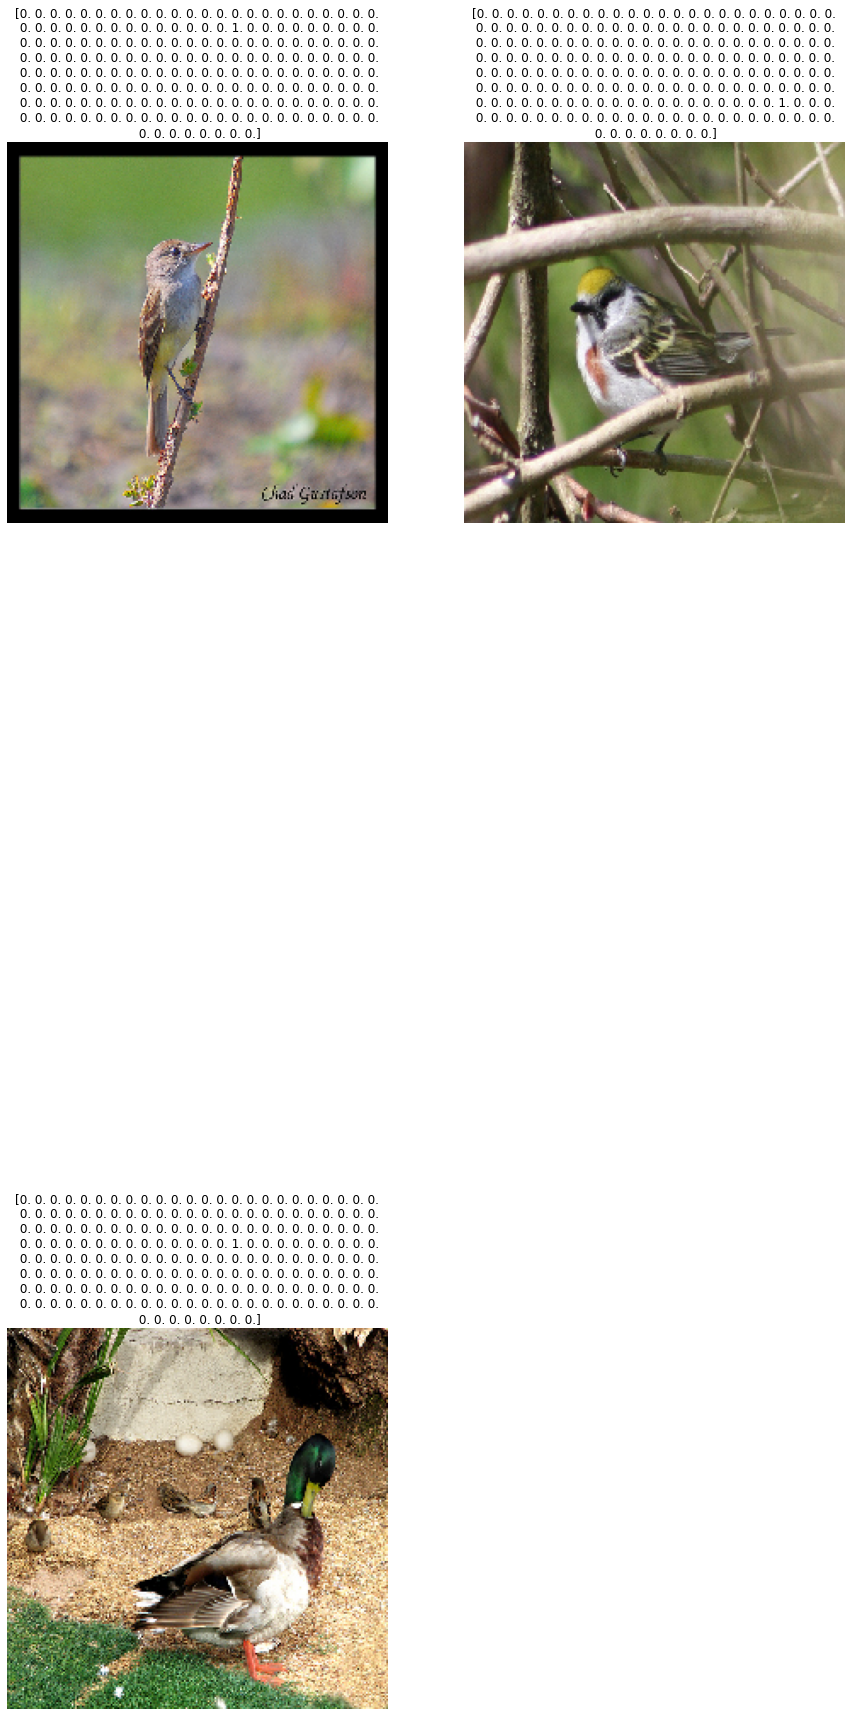

In [ ]:
pintaMIE(x_train[0:3], y_train[0:3], figsize=(15,40))
pintaMIE(x_test[0:3], y_test[0:3], figsize=(15,40))

Creamos una función para evaluar el modelo en función de si usamos un tipo de conjunto de datos u otro. Para el segundo conjunto de datos, detallado más arriba, tendremos que activar la variable booleana __test__ que por defecto está a _false_, para el segundo conjunto de datos no habrá que hacer nada o ponerla de manera explícita a _false_.

In [ ]:
def fit_val_resnet(model, test=False, aug=False, verbose=0):

  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

  if test:
    local_train_iterator     = train_iterator_2
    local_aug_train_iterator = aug_train_iterator_2
    local_val_iterator       = test_val_iterator_2
    local_test_iterator      = test_iterator_2
  else:
    local_train_iterator     = train_iterator
    local_aug_train_iterator = aug_train_iterator
    local_val_iterator       = val_iterator
    local_test_iterator      = test_val_iterator

  if aug:
    mostrarEvolucion(model.fit(local_aug_train_iterator,
            validation_data=local_val_iterator,
            steps_per_epoch=len(x_train)/batch_size,
            epochs=epochs,
            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)],
            validation_steps=len(x_val)/batch_size,
            verbose=verbose
            ))
  else:
      mostrarEvolucion(model.fit(local_train_iterator,
                validation_data=local_val_iterator,
                steps_per_epoch=len(x_train)/batch_size,
                epochs=epochs,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)],
                validation_steps=len(x_val)/batch_size,
                verbose=verbose
                ))
    
  # Validación o Evaluación
  score = model.evaluate(local_test_iterator,verbose=verbose)


  print('Accuracy:', score[1])
  print('Loss:', score[0])

## 1-A

Creamos la primera aproximación a ResNet, la entrenamos y la ejecutamos

In [ ]:
def ResNet_v1():

  # ResNet50 con los pesos de ImageNet sin la capa de salida.
  resnet50 = ResNet50(include_top = False, weights = 'imagenet', pooling = 'avg')

  #Para que no cambien los pesos
  resnet50.trainable = False

  #Añadimos la capa de salida con 200 clases
  x = Dense(200, activation='softmax')(resnet50.output)

  # Completamos el modelo 
  model= keras.Model(inputs=resnet50.inputs, outputs=x)

  return model

def ResNet_v2():
    # Tomamos el modelo y le quitamos la ultima capa
    resnet50 = ResNet50(include_top = False, weights = 'imagenet', pooling = 'avg', input_shape=(224,224,3))
    
    # Para que no cambien los pesos  
    resnet50.trainable = False

    # Añadimos mas capas
    x = Dropout(0.6, name='Dropout_1')(resnet50.output)
    x = Dense(4096, activation='relu', name='Dense_1')(x)
    x = Dropout(0.6, name='Dropout_2')(x)
    x = Dense(200, activation='softmax', name='DenseSoftmax')(x)
    model=keras.Model(inputs=resnet50.input, outputs=x)

    return model

Ejecutamos con el primer conjunto de datos "Test=False", la version 1 dos veces, una sin aumentar los datos en el entrenamiendo y otra aumentandolos. 

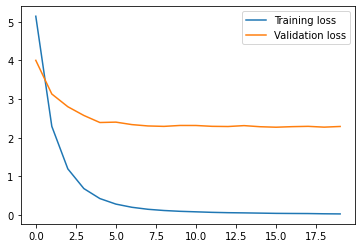

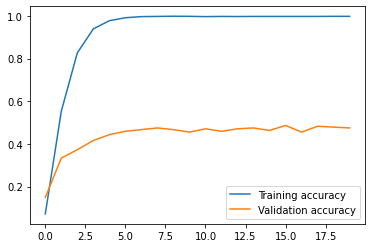

Accuracy: 0.5088889002799988
Loss: 2.0756959915161133


In [ ]:
resnet1 = ResNet_v1()
fit_val_resnet(resnet1, test=False, aug=False, verbose=0)

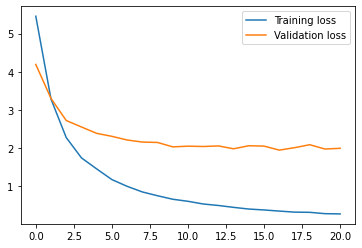

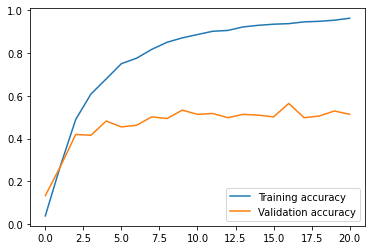

Accuracy: 0.41999998688697815
Loss: 2.354219675064087


In [ ]:
resnet1 = ResNet_v1()
fit_val_resnet(resnet1, test=False, aug=True, verbose=0)

Ejecutamos ahora el segundo modelo de igual forma que el anterior. 

Epoch 1/30
35/35 [==============================] - 49s 750ms/step - loss: 6.0068 - accuracy: 0.0257 - val_loss: 4.4217 - val_accuracy: 0.1529
Epoch 2/30
35/35 [==============================] - 21s 587ms/step - loss: 3.9163 - accuracy: 0.1551 - val_loss: 3.4611 - val_accuracy: 0.2235
Epoch 3/30
35/35 [==============================] - 21s 579ms/step - loss: 3.1295 - accuracy: 0.2858 - val_loss: 2.9216 - val_accuracy: 0.3059
Epoch 4/30
35/35 [==============================] - 21s 577ms/step - loss: 2.5287 - accuracy: 0.3861 - val_loss: 2.6025 - val_accuracy: 0.3373
Epoch 5/30
35/35 [==============================] - 21s 578ms/step - loss: 2.1009 - accuracy: 0.4641 - val_loss: 2.4375 - val_accuracy: 0.3922
Epoch 6/30
35/35 [==============================] - 21s 579ms/step - loss: 1.8208 - accuracy: 0.5133 - val_loss: 2.2646 - val_accuracy: 0.3961
Epoch 7/30
35/35 [==============================] - 21s 572ms/step - loss: 1.5877 - accuracy: 0.5673 - val_loss: 2.2673 - val_accuracy: 0.4392

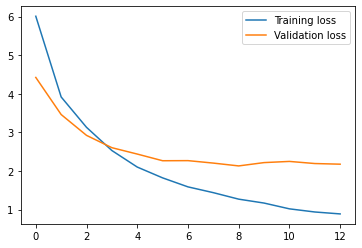

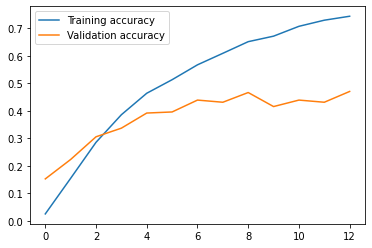

8/8 [==============================] - 4s 546ms/step - loss: 2.1057 - accuracy: 0.4511
Accuracy: 0.4511111080646515
Loss: 2.1056854724884033


In [ ]:
resnet2 = ResNet_v2()
fit_val_resnet(resnet2,aug=False,test=False,verbose=1)

Epoch 1/30
35/35 [==============================] - 65s 1s/step - loss: 6.2636 - accuracy: 0.0157 - val_loss: 4.7796 - val_accuracy: 0.0431
Epoch 2/30
35/35 [==============================] - 36s 992ms/step - loss: 4.6778 - accuracy: 0.0728 - val_loss: 4.0958 - val_accuracy: 0.1176
Epoch 3/30
35/35 [==============================] - 35s 964ms/step - loss: 4.1133 - accuracy: 0.1281 - val_loss: 3.5308 - val_accuracy: 0.1882
Epoch 4/30
35/35 [==============================] - 35s 965ms/step - loss: 3.7556 - accuracy: 0.1786 - val_loss: 3.3603 - val_accuracy: 0.2118
Epoch 5/30
35/35 [==============================] - 35s 962ms/step - loss: 3.4228 - accuracy: 0.2205 - val_loss: 3.0237 - val_accuracy: 0.2588
Epoch 6/30
35/35 [==============================] - 40s 1s/step - loss: 3.2397 - accuracy: 0.2453 - val_loss: 2.8545 - val_accuracy: 0.2980
Epoch 7/30
35/35 [==============================] - 42s 1s/step - loss: 2.9940 - accuracy: 0.2902 - val_loss: 2.7156 - val_accuracy: 0.3294
Epoch 8/

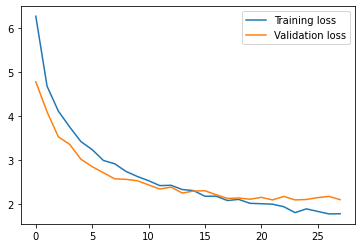

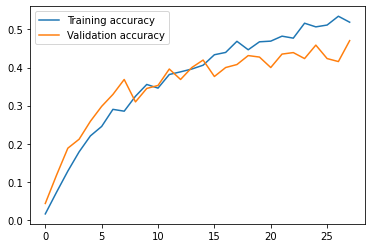

8/8 [==============================] - 5s 550ms/step - loss: 2.1654 - accuracy: 0.4600
Accuracy: 0.46000000834465027
Loss: 2.165424108505249


In [ ]:
resnet2 = ResNet_v2()
fit_val_resnet(resnet2,aug=True,test=False,verbose=1)

## 1.B

In [ ]:
def ResNet_v3():

  # Tomamos el modelo y le quitamos la ultima capa
  resnet50 = ResNet50(include_top = False, weights = 'imagenet', pooling = None)
  
  resnet50.trainable = False

  x = Conv2D(512, 3, name='Conv2D_1', padding='same')(resnet50.output)
  x = BatchNormalization(name='BatchNorm_1')(x)
  x = Activation(keras.activations.relu, name='ReLu_1')(x)
  
  x = Conv2D(256, 3, name='Conv2D_2', padding='same')(x)
  x = BatchNormalization(name='BatchNorm_2')(x)
  x = Activation(keras.activations.relu, name='ReLu_2')(x)

  x = Conv2D(256, 3, name='Conv2D_3', padding='same')(x)
  x = BatchNormalization(name='BatchNorm_3')(x)
  x = Activation(keras.activations.relu, name='ReLu_3')(x)
  x = GlobalAveragePooling2D()(x)

  x = Dropout(0.6, name='Dropout_2')(x)
  x = Dense(200, activation='softmax', name='DenseSoftmax')(x)
  
  model=keras.Model(inputs=resnet50.input, outputs=x)
  
  return model

Epoch 1/30
35/35 [==============================] - 55s 859ms/step - loss: 5.1985 - accuracy: 0.0218 - val_loss: 6.1113 - val_accuracy: 0.0471
Epoch 2/30
35/35 [==============================] - 23s 647ms/step - loss: 4.2186 - accuracy: 0.1146 - val_loss: 3.7296 - val_accuracy: 0.1137
Epoch 3/30
35/35 [==============================] - 24s 661ms/step - loss: 3.4919 - accuracy: 0.2318 - val_loss: 3.3461 - val_accuracy: 0.1882
Epoch 4/30
35/35 [==============================] - 24s 663ms/step - loss: 2.8166 - accuracy: 0.3669 - val_loss: 3.1259 - val_accuracy: 0.2745
Epoch 5/30
35/35 [==============================] - 23s 653ms/step - loss: 2.2314 - accuracy: 0.5011 - val_loss: 2.9097 - val_accuracy: 0.3451
Epoch 6/30
35/35 [==============================] - 23s 646ms/step - loss: 1.7024 - accuracy: 0.6471 - val_loss: 2.8213 - val_accuracy: 0.3765
Epoch 7/30
35/35 [==============================] - 24s 664ms/step - loss: 1.2310 - accuracy: 0.7900 - val_loss: 2.6019 - val_accuracy: 0.3961

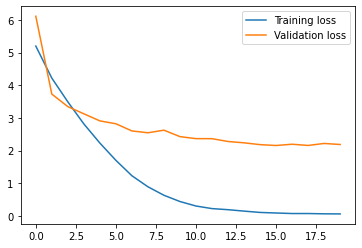

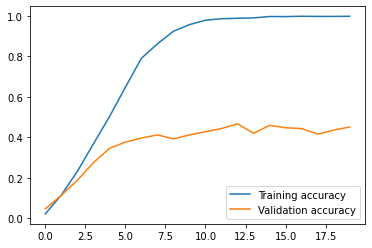

8/8 [==============================] - 5s 599ms/step - loss: 2.1245 - accuracy: 0.5044
Accuracy: 0.504444420337677
Loss: 2.1245038509368896


In [ ]:
resnet3 = ResNet_v3()
fit_val_resnet(resnet3,aug=False,test=False,verbose=1)

Epoch 1/30
35/35 [==============================] - 60s 1s/step - loss: 5.2766 - accuracy: 0.0170 - val_loss: 8.0561 - val_accuracy: 0.0431
Epoch 2/30
35/35 [==============================] - 36s 990ms/step - loss: 4.5201 - accuracy: 0.0671 - val_loss: 4.0199 - val_accuracy: 0.1176
Epoch 3/30
35/35 [==============================] - 38s 1s/step - loss: 4.0082 - accuracy: 0.1255 - val_loss: 3.5498 - val_accuracy: 0.1608
Epoch 4/30
35/35 [==============================] - 36s 1s/step - loss: 3.5836 - accuracy: 0.1961 - val_loss: 3.0775 - val_accuracy: 0.2549
Epoch 5/30
35/35 [==============================] - 44s 1s/step - loss: 3.2276 - accuracy: 0.2431 - val_loss: 2.9585 - val_accuracy: 0.2667
Epoch 6/30
35/35 [==============================] - 46s 1s/step - loss: 2.9412 - accuracy: 0.3124 - val_loss: 2.7127 - val_accuracy: 0.3098
Epoch 7/30
35/35 [==============================] - 39s 1s/step - loss: 2.6726 - accuracy: 0.3673 - val_loss: 2.7281 - val_accuracy: 0.3294
Epoch 8/30
35/35 

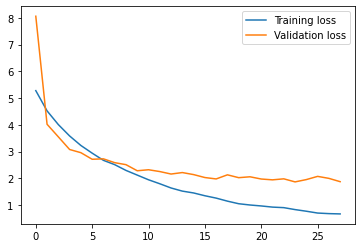

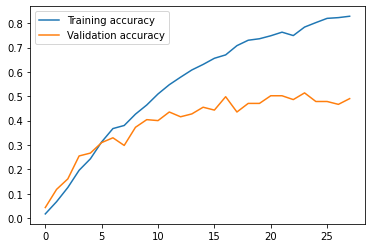

8/8 [==============================] - 5s 596ms/step - loss: 2.1767 - accuracy: 0.4844
Accuracy: 0.48444443941116333
Loss: 2.1766693592071533


In [ ]:
resnet3 = ResNet_v3()
fit_val_resnet(resnet3,aug=True,test=False,verbose=1)

**NOTA**: Con datos aumentados tarda más en entrenar, decirlo en la memoria, pero se reduce mucho el sobreajuste

## Evaluación en el conjunto de test 1A y 1B

Epoch 1/30
35/35 [==============================] - 46s 683ms/step - loss: 5.1012 - accuracy: 0.0501 - val_loss: 3.8644 - val_accuracy: 0.1484
Epoch 2/30
35/35 [==============================] - 21s 577ms/step - loss: 2.3765 - accuracy: 0.5218 - val_loss: 2.8949 - val_accuracy: 0.3125
Epoch 3/30
35/35 [==============================] - 21s 573ms/step - loss: 1.2898 - accuracy: 0.7925 - val_loss: 2.5520 - val_accuracy: 0.4102
Epoch 4/30
35/35 [==============================] - 21s 576ms/step - loss: 0.7820 - accuracy: 0.9124 - val_loss: 2.3454 - val_accuracy: 0.4414
Epoch 5/30
35/35 [==============================] - 20s 571ms/step - loss: 0.5021 - accuracy: 0.9616 - val_loss: 2.2480 - val_accuracy: 0.4570
Epoch 6/30
35/35 [==============================] - 20s 571ms/step - loss: 0.3379 - accuracy: 0.9847 - val_loss: 2.0936 - val_accuracy: 0.4805
Epoch 7/30
35/35 [==============================] - 21s 574ms/step - loss: 0.2434 - accuracy: 0.9935 - val_loss: 2.2400 - val_accuracy: 0.4727

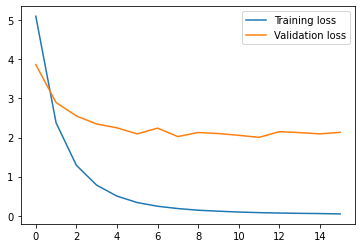

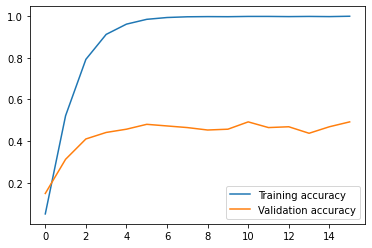

48/48 [==============================] - 26s 539ms/step - loss: 2.3849 - accuracy: 0.4207
Accuracy: 0.4207055866718292
Loss: 2.384929895401001


In [ ]:
resnet1 = ResNet_v1()
fit_val_resnet(resnet1, test=True, aug=False, verbose=1)

94781440/94765736 [==============================] - 2s 0us/step
Epoch 1/30
35/35 [==============================] - 50s 995ms/step - loss: 6.3150 - accuracy: 0.0196 - val_loss: 4.8052 - val_accuracy: 0.1055
Epoch 2/30
35/35 [==============================] - 33s 918ms/step - loss: 4.6878 - accuracy: 0.0684 - val_loss: 4.0841 - val_accuracy: 0.1680
Epoch 3/30
35/35 [==============================] - 33s 917ms/step - loss: 4.1731 - accuracy: 0.1238 - val_loss: 3.5512 - val_accuracy: 0.1992
Epoch 4/30
35/35 [==============================] - 33s 914ms/step - loss: 3.7962 - accuracy: 0.1678 - val_loss: 3.2928 - val_accuracy: 0.2344
Epoch 5/30
35/35 [==============================] - 33s 917ms/step - loss: 3.4934 - accuracy: 0.2110 - val_loss: 3.1515 - val_accuracy: 0.2969
Epoch 6/30
35/35 [==============================] - 33s 918ms/step - loss: 3.2522 - accuracy: 0.2393 - val_loss: 2.8243 - val_accuracy: 0.3555
Epoch 7/30
35/35 [==============================] - 33s 915ms/step - loss: 3.

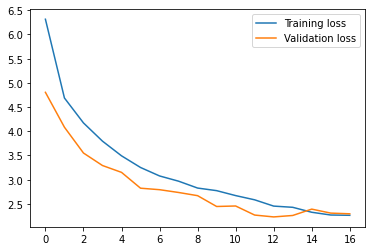

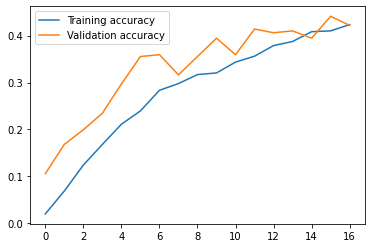

48/48 [==============================] - 21s 437ms/step - loss: 2.4830 - accuracy: 0.3782
Accuracy: 0.3781734108924866
Loss: 2.483037233352661


In [ ]:
resnet2 = ResNet_v2()
fit_val_resnet(resnet2,aug=True,test=True,verbose=1)

Epoch 1/30
35/35 [==============================] - 40s 638ms/step - loss: 5.1946 - accuracy: 0.0227 - val_loss: 8.5480 - val_accuracy: 0.0352
Epoch 2/30
35/35 [==============================] - 19s 527ms/step - loss: 4.2405 - accuracy: 0.1016 - val_loss: 3.9875 - val_accuracy: 0.1172
Epoch 3/30
35/35 [==============================] - 19s 526ms/step - loss: 3.5658 - accuracy: 0.2145 - val_loss: 3.3904 - val_accuracy: 0.1953
Epoch 4/30
35/35 [==============================] - 19s 528ms/step - loss: 2.9593 - accuracy: 0.3370 - val_loss: 3.0315 - val_accuracy: 0.3047
Epoch 5/30
35/35 [==============================] - 19s 524ms/step - loss: 2.3516 - accuracy: 0.4778 - val_loss: 2.9137 - val_accuracy: 0.3750
Epoch 6/30
35/35 [==============================] - 19s 519ms/step - loss: 1.8820 - accuracy: 0.6059 - val_loss: 2.9270 - val_accuracy: 0.3281
Epoch 7/30
35/35 [==============================] - 19s 526ms/step - loss: 1.4667 - accuracy: 0.7014 - val_loss: 2.7706 - val_accuracy: 0.3906

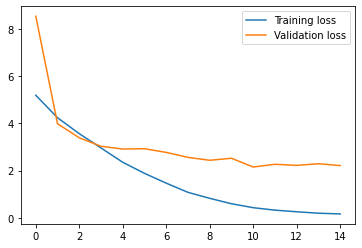

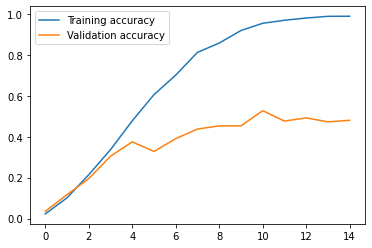

48/48 [==============================] - 22s 461ms/step - loss: 2.5847 - accuracy: 0.3904
Accuracy: 0.3903725743293762
Loss: 2.584685802459717


In [ ]:
resnet3 = ResNet_v3()
fit_val_resnet(resnet3,aug=False,test=True,verbose=1)

## 2) Fine tuning

In [6]:
def fine_tuning(aug=False, test=False, verbose=0):
  
  # En función del tipo de conjunto de datos (primero o segundo) que antes se comentó
  # Y en función de su usamos aumento de dtos o no durante el entrenamiendo 
  # Establecemos los conjuntos de training, test, validación.
    if test:
      if aug: 
        local_train_iterator = aug_train_iterator_2
      else:
        local_train_iterator     = train_iterator_2

      local_val_iterator       = test_val_iterator_2
      local_test_iterator      = test_iterator_2
      local_x_train            = xx_train
      local_x_val              = xx_test_val
      local_y_train            = yy_train
      local_y_val              = yy_test_val
     
    else:
      if aug:
        local_train_iterator = aug_train_iterator
      else:
        local_train_iterator     = train_iterator  
      local_val_iterator       = val_iterator
      local_test_iterator      = test_val_iterator
      local_x_train            = x_train
      local_x_val              = x_val
      local_y_train            = y_train
      local_y_val              = y_val


    # Definir el modelo base con los pesos de ImageNet sin la capa de salida.
    resnet50 = ResNet50(include_top = False, weights = 'imagenet', pooling = 'avg')
    resnet50.trainable = False
    x = Dense(200, activation='softmax')(resnet50.output)
    model = keras.Model(inputs=resnet50.inputs, outputs=x)
    
    # Entrenamiento de la capa de salida
    epochs = 30
    batch_size = 64

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

    model.fit(local_train_iterator,
            validation_data=local_val_iterator,
            steps_per_epoch=len(local_x_train)/batch_size,
            epochs=epochs,
            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)],
            validation_steps=len(local_x_val)/batch_size,
            verbose=verbose)

    # Descongelamos y ajustamos el reto de la red
    resnet50.trainable = True
    epochs = 10
    batch_size = 32
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(1e-5), metrics=['accuracy'])

    ## Usamos DataImageGenerator para aumentar los datos y normalizar (normalizamos ya que estmaos cambiando el tamaño del batch)

    # Entrenamiento
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    datagen.fit(local_x_train)
    train_iterator2 = datagen.flow(local_x_train, local_y_train, batch_size=batch_size)     # Entrenar
    val_iterator2  = datagen.flow(local_x_val, local_y_val, batch_size=batch_size)      # Validacion en el fit

    
    mostrarEvolucion(model.fit(train_iterator2,
            validation_data=val_iterator2,
            steps_per_epoch=len(local_x_train)/batch_size,
            epochs=epochs,
            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)],
            validation_steps=len(local_x_val)/batch_size,
            verbose=verbose
            ))
    
   # Validación
    score = model.evaluate(local_test_iterator,verbose=verbose)
    print('Accuracy:', score[1])
    print('Loss:', score[0])

Epoch 1/30
35/35 [==============================] - 42s 615ms/step - loss: 5.0718 - accuracy: 0.0697 - val_loss: 3.8609 - val_accuracy: 0.1647
Epoch 2/30
35/35 [==============================] - 17s 474ms/step - loss: 2.2801 - accuracy: 0.5412 - val_loss: 2.9098 - val_accuracy: 0.3137
Epoch 3/30
35/35 [==============================] - 17s 473ms/step - loss: 1.1851 - accuracy: 0.8257 - val_loss: 2.4411 - val_accuracy: 0.4078
Epoch 4/30
35/35 [==============================] - 17s 474ms/step - loss: 0.6740 - accuracy: 0.9342 - val_loss: 2.2779 - val_accuracy: 0.4431
Epoch 5/30
35/35 [==============================] - 17s 473ms/step - loss: 0.4175 - accuracy: 0.9773 - val_loss: 2.1641 - val_accuracy: 0.4510
Epoch 6/30
35/35 [==============================] - 17s 473ms/step - loss: 0.2788 - accuracy: 0.9913 - val_loss: 2.0878 - val_accuracy: 0.4510
Epoch 7/30
35/35 [==============================] - 17s 473ms/step - loss: 0.2044 - accuracy: 0.9939 - val_loss: 2.0576 - val_accuracy: 0.4667

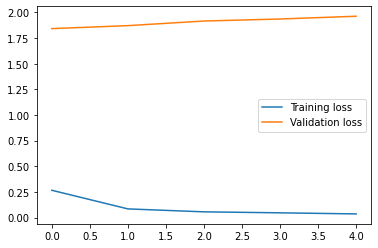

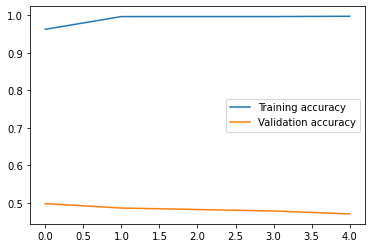

8/8 [==============================] - 4s 431ms/step - loss: 2.0468 - accuracy: 0.4822
Accuracy: 0.48222222924232483
Loss: 2.0468368530273438


In [ ]:
fine_tuning(aug=False,test=False,verbose=1)

Epoch 1/30
35/35 [==============================] - 56s 1s/step - loss: 5.4908 - accuracy: 0.0388 - val_loss: 4.3255 - val_accuracy: 0.1137
Epoch 2/30
35/35 [==============================] - 33s 913ms/step - loss: 3.2906 - accuracy: 0.2793 - val_loss: 3.3807 - val_accuracy: 0.2549
Epoch 3/30
35/35 [==============================] - 33s 910ms/step - loss: 2.3594 - accuracy: 0.4623 - val_loss: 2.8906 - val_accuracy: 0.3059
Epoch 4/30
35/35 [==============================] - 33s 910ms/step - loss: 1.8211 - accuracy: 0.5843 - val_loss: 2.6846 - val_accuracy: 0.3804
Epoch 5/30
35/35 [==============================] - 33s 912ms/step - loss: 1.4419 - accuracy: 0.6771 - val_loss: 2.4345 - val_accuracy: 0.4275
Epoch 6/30
35/35 [==============================] - 33s 908ms/step - loss: 1.1929 - accuracy: 0.7364 - val_loss: 2.3533 - val_accuracy: 0.4549
Epoch 7/30
35/35 [==============================] - 33s 912ms/step - loss: 1.0103 - accuracy: 0.7852 - val_loss: 2.2384 - val_accuracy: 0.4667
Ep

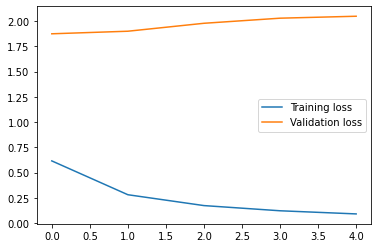

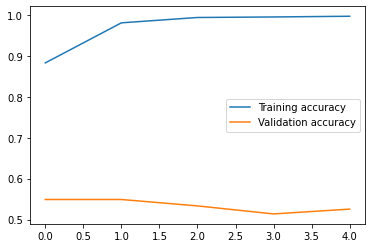

8/8 [==============================] - 4s 435ms/step - loss: 1.8999 - accuracy: 0.5089
Accuracy: 0.5088889002799988
Loss: 1.8998557329177856


In [ ]:
fine_tuning(aug=True,test=False,verbose=1)

#### Fine tuning de la versión 3.
Este modelo no se ha incluido en la memoria porque ha sido de prueba simplemente.

In [ ]:
def fine_tuning_v3(aug=False, test=False, verbose=0):
  
    if test:
      if aug: 
        local_train_iterator = aug_train_iterator_2
      else:
        local_train_iterator     = train_iterator_2
      local_val_iterator       = test_val_iterator_2
      local_test_iterator      = test_iterator_2
      local_x_train            = xx_train
      local_x_val              = xx_test_val
      local_y_train            = yy_train
      local_y_val              = yy_test_val
     
    else:
      if aug:
        local_train_iterator = aug_train_iterator
      else:
        local_train_iterator     = train_iterator  
      local_val_iterator       = val_iterator
      local_test_iterator      = test_val_iterator
      local_x_train            = x_train
      local_x_val              = x_val
      local_y_train            = y_train
      local_y_val              = y_val


    # Tomamos el modelo, le quitamos la ultima capa y añadimos las de ResNet_v3
    resnet50 = ResNet50(include_top = False, weights = 'imagenet', pooling = None)

    resnet50.trainable = False

    x = Conv2D(512, 3, name='Conv2D_1', padding='same')(resnet50.output)
    x = BatchNormalization(name='BatchNorm_1')(x)
    x = Activation(keras.activations.relu, name='ReLu_1')(x)

    x = Conv2D(256, 3, name='Conv2D_2', padding='same')(x)
    x = BatchNormalization(name='BatchNorm_2')(x)
    x = Activation(keras.activations.relu, name='ReLu_2')(x)

    x = Conv2D(256, 3, name='Conv2D_3', padding='same')(x)
    x = BatchNormalization(name='BatchNorm_3')(x)
    x = Activation(keras.activations.relu, name='ReLu_3')(x)
    x = GlobalAveragePooling2D()(x)

    x = Dropout(0.6, name='Dropout_2')(x)
    x = Dense(200, activation='softmax', name='DenseSoftmax')(x)

    model=keras.Model(inputs=resnet50.input, outputs=x)
  
    # Entrenamiento de la capa de salida
    epochs = 30
    batch_size = 64

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

    model.fit(local_train_iterator,
            validation_data=local_val_iterator,
            steps_per_epoch=len(local_x_train)/batch_size,
            epochs=epochs,
            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)],
            validation_steps=len(local_x_val)/batch_size,
            verbose=verbose)

    # Descongelamos las capass y Ajustamos del resto de la red
    resnet50.trainable = True
    epochs = 10
    batch_size = 32
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(1e-5), metrics=['accuracy'])

    ## Usamos DataImageGenerator para aumentar los datos y normalizar 

    # Entrenamiento
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    datagen.fit(local_x_train)
    train_iterator2 = datagen.flow(local_x_train, local_y_train, batch_size=batch_size)     # Entrenar
    val_iterator2  = datagen.flow(local_x_val, local_y_val, batch_size=batch_size)      # Validacion en el fit

    
    mostrarEvolucion(model.fit(train_iterator2,
            validation_data=val_iterator2,
            steps_per_epoch=len(local_x_train)/batch_size,
            epochs=epochs,
            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)],
            validation_steps=len(local_x_val)/batch_size,
            verbose=verbose
            ))
    
  # Validación
    score = model.evaluate(local_test_iterator,verbose=verbose)
    print('Accuracy:', score[1])
    print('Loss:', score[0])

94781440/94765736 [==============================] - 2s 0us/step
Epoch 1/30
35/35 [==============================] - 45s 835ms/step - loss: 5.1904 - accuracy: 0.0270 - val_loss: 6.4728 - val_accuracy: 0.0431
Epoch 2/30
35/35 [==============================] - 23s 638ms/step - loss: 4.2552 - accuracy: 0.1233 - val_loss: 3.9277 - val_accuracy: 0.1059
Epoch 3/30
35/35 [==============================] - 23s 637ms/step - loss: 3.5340 - accuracy: 0.2349 - val_loss: 3.1925 - val_accuracy: 0.2392
Epoch 4/30
35/35 [==============================] - 23s 640ms/step - loss: 2.8725 - accuracy: 0.3551 - val_loss: 2.8783 - val_accuracy: 0.2941
Epoch 5/30
35/35 [==============================] - 23s 637ms/step - loss: 2.2380 - accuracy: 0.5115 - val_loss: 2.7845 - val_accuracy: 0.3451
Epoch 6/30
35/35 [==============================] - 23s 637ms/step - loss: 1.7448 - accuracy: 0.6405 - val_loss: 2.6249 - val_accuracy: 0.4000
Epoch 7/30
35/35 [==============================] - 23s 637ms/step - loss: 1.

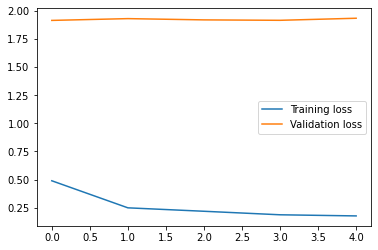

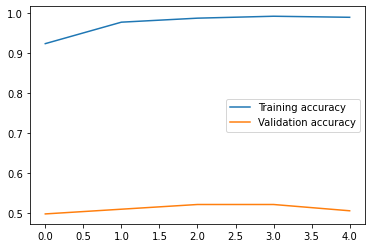

8/8 [==============================] - 5s 594ms/step - loss: 2.0766 - accuracy: 0.5022
Accuracy: 0.5022222399711609
Loss: 2.076586961746216


In [ ]:
fine_tuning_v3(aug=False,test=False,verbose=1)

Epoch 1/30
35/35 [==============================] - 64s 1s/step - loss: 5.2394 - accuracy: 0.0196 - val_loss: 10.3076 - val_accuracy: 0.0275
Epoch 2/30
35/35 [==============================] - 37s 1s/step - loss: 4.5230 - accuracy: 0.0641 - val_loss: 4.0759 - val_accuracy: 0.0941
Epoch 3/30
35/35 [==============================] - 35s 969ms/step - loss: 4.0232 - accuracy: 0.1281 - val_loss: 3.7267 - val_accuracy: 0.1608
Epoch 4/30
35/35 [==============================] - 35s 966ms/step - loss: 3.6372 - accuracy: 0.1821 - val_loss: 3.2427 - val_accuracy: 0.2314
Epoch 5/30
35/35 [==============================] - 35s 966ms/step - loss: 3.2754 - accuracy: 0.2336 - val_loss: 3.0711 - val_accuracy: 0.2392
Epoch 6/30
35/35 [==============================] - 35s 972ms/step - loss: 2.9831 - accuracy: 0.2998 - val_loss: 2.8467 - val_accuracy: 0.2941
Epoch 7/30
35/35 [==============================] - 35s 965ms/step - loss: 2.6857 - accuracy: 0.3560 - val_loss: 2.8196 - val_accuracy: 0.3412
Epoc

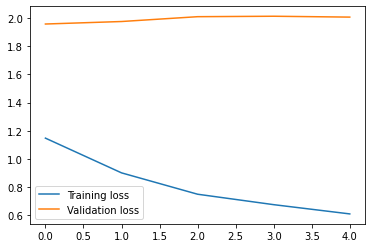

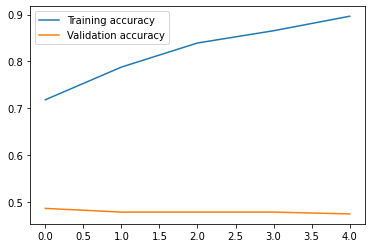

8/8 [==============================] - 5s 591ms/step - loss: 2.0554 - accuracy: 0.4933
Accuracy: 0.4933333396911621
Loss: 2.055438995361328


In [ ]:
fine_tuning_v3(aug=True,test=False,verbose=1)

## Evaluación en test

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/30
39/39 [==============================] - 38s 580ms/step - loss: 4.9775 - accuracy: 0.0835 - val_loss: 3.8806 - val_accuracy: 0.1778
Epoch 2/30
39/39 [==============================] - 20s 491ms/step - loss: 2.1285 - accuracy: 0.5831 - val_loss: 2.9896 - val_accuracy: 0.3133
Epoch 3/30
39/39 [==============================] - 20s 490ms/step - loss: 1.1033 - accuracy: 0.8255 - val_loss: 2.6022 - val_accuracy: 0.3867
Epoch 4/30
39/39 [==============================] - 19s 490ms/step - loss: 0.6436 - accuracy: 0.9408 - val_loss: 2.3609 - val_accuracy: 0.4133
Epoch 5/30
39/39 [==============================] - 19s 490ms/step - loss: 0.4075 - accuracy: 0.9725 - val_loss: 2.3203 - val_accuracy: 0.4422
Epoch 6/30
39/39 [==============================] - 20s 490ms/step - loss: 0.2721 - accuracy: 0.9922 - val_loss: 2.2566 - val_accuracy: 0.4489
Epoch 7/30
39/39 [==============================] - 19s 489ms/step - loss: 0.

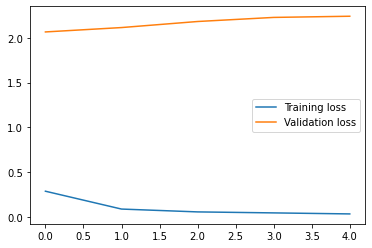

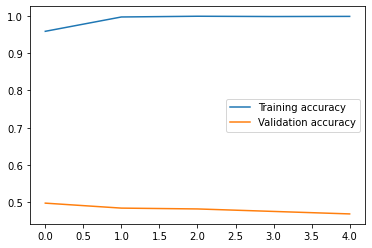

48/48 [==============================] - 21s 428ms/step - loss: 2.2815 - accuracy: 0.4438
Accuracy: 0.44378504157066345
Loss: 2.2814784049987793


In [13]:
fine_tuning(aug=False,test=True,verbose=1)

Epoch 1/30
39/39 [==============================] - 30s 597ms/step - loss: 5.1668 - accuracy: 0.0275 - val_loss: 9.8729 - val_accuracy: 0.0533
Epoch 2/30
39/39 [==============================] - 22s 555ms/step - loss: 4.0950 - accuracy: 0.1027 - val_loss: 3.7181 - val_accuracy: 0.1311
Epoch 3/30
39/39 [==============================] - 22s 553ms/step - loss: 3.3374 - accuracy: 0.2106 - val_loss: 3.0755 - val_accuracy: 0.2089
Epoch 4/30
39/39 [==============================] - 22s 552ms/step - loss: 2.7148 - accuracy: 0.3443 - val_loss: 2.8923 - val_accuracy: 0.2800
Epoch 5/30
39/39 [==============================] - 22s 555ms/step - loss: 2.1151 - accuracy: 0.4831 - val_loss: 2.7632 - val_accuracy: 0.3311
Epoch 6/30
39/39 [==============================] - 22s 552ms/step - loss: 1.6582 - accuracy: 0.6027 - val_loss: 2.6687 - val_accuracy: 0.3444
Epoch 7/30
39/39 [==============================] - 22s 552ms/step - loss: 1.2418 - accuracy: 0.7173 - val_loss: 2.5275 - val_accuracy: 0.4222

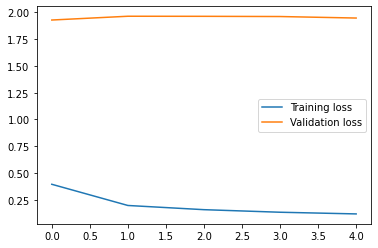

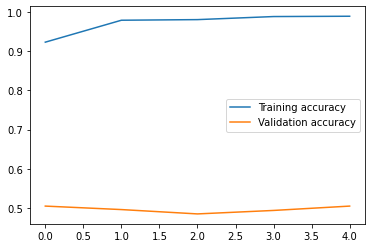

48/48 [==============================] - 22s 463ms/step - loss: 2.3651 - accuracy: 0.4313
Accuracy: 0.43125617504119873
Loss: 2.3651273250579834


In [ ]:
fine_tuning_v3(aug=False,test=True,verbose=1)